# Archivos:
Luego del original, sell_in q es el source con millones de datos

- "group": solo numero de grupo, periodo, y tb. Punto de partida para las predicciones
- "prod_stats": identificador por grupo, media, maximos, minimos y otras estadisticas
- "prod_data_group": informacion sobre los productos, agrupado nivel grupo (groupby cats, descripcion etc)
- "prod_data_ungroup": informacion sobre los productos original, intacto del source
- "stock_data": info de stocks, intacto del source
- "norm": la informacion de "group" normalizada por media y desvio, columna tn_norm
- "lag": sigue luego de norm, mismas filas pero incorporando todo el feature engineering (no solo lags)
- "train": set de datos para train a partir de "lag" con los meses segun config
- "test": set de datos para test a partir de "lag" con los meses segun config
- "futuro": set de datos para futuro a partir de "lag" con los meses segun config
- "pred_test": predicciones de test, con algunas columnas accesorias
- "pred_futuro": predicciones de futuro, con algunas columnas accesorias
- "kaggle": prediccion en formato kaggle para el submit

# Pendientes

* HECHO - convertir control en diccionario
* script mas complejo para proporcion
    - puede haber nulos, solucionar los faltantes
    - poder darle una lista de meses
* HECHO - arreglar scripts para control
* reescribir optimizacion de hiperparam
* arreglar teste de perdida al final

In [25]:
from datetime import datetime
import pandas as pd
import sys
import json
import os

In [26]:
ejecutar_scripts = {
    '01_LecturaDatos' : True,
    '02_normaliza': True,
    '02b_DTW' : True,
    '03_features' : True,
    '04_crear_train_set' : True,
    '05_lightgbm' : True,
    '06_evaluar_prediccion' : True	
}

In [27]:
NOMBRE_EXPERIMENTO = '2024-07-09_Candidato'
FOLDER = f'./Experimentos/{NOMBRE_EXPERIMENTO}/'

dibujar_pesos = False
lgbm_params = {
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'boosting_type': 'gbdt',
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
    'num_leaves': 70,
    'max_depth': -1,
    #'n_estimators': 50, 
    'feature_fraction': 0.9,
    'max_bin': 1023,
    'learning_rate': 0.01,
    'force_col_wise' : True,
    'num_threads' : 16,
    'verbose' : 1,
    'early_stopping_rounds' : 10,
    'weight_column': 'mean_weight', #aca elegimos la metrica para el weight de LGBM
}

gen_config = {
    "nombre_exp" : NOMBRE_EXPERIMENTO,
    "folder" : FOLDER,

    #PATHS ----------------------------------------------------------------
    #fase 1
    "path_group" : "01_group.parquet",
    "path_prod_stats" : "01_prod_stats.parquet",
    "path_prod_data" : "01_prod_data.parquet", #este es a nivel prodcust, retuve el nombre prod de antes del cambio
    "path_overall_prod_stats" : "01_overall_prod_stats.parquet",
    "path_stock_data" : "01_stock_data.parquet",
    #fase 2
    "path_norm" : "02_norm.parquet",
    #"path_transform_stats" : "02_transform_stats.parquet",
    #fase 2b
    "path_dtw" : "02b_dtw.parquet",
    "path_traindtw" : "02b_traindtw.npy",
    "path_fitdtw" : "02b_fitdtw.npy",
    "path_dtw_model" : "02b_dtw_model",
    #fase 3
    "path_lag" : "03_lag.parquet",
    #fase 4
    "path_train" : "04_train.parquet",
    "path_test" : "04_test.parquet",
    "path_futuro" : "04_futuro.parquet",
    #fase 5
    "path_pred_test" : "05_pred_test.parquet",
    "path_pred_futuro" : "05_pred_futuro.parquet",
    #fase 6
    "path_kaggle" : f"kaggle_{NOMBRE_EXPERIMENTO}.csv",
    #fase 7
    "path_semillerio" : f"semillerio_{NOMBRE_EXPERIMENTO}.csv",

    #VARIABLES -------------------------------------------------------------
    #fase 1 LEER DATOS
    
    #fase 2 NORMALIZAR
    "var_escalado" : 'tn_robust', #metodo de escalado: tn_trans (power) tn_standard (standard) tn_robust (robusta)
    "var_withmean" : False,
    #fase 2b DTW
    "var_ejecutar_dtw": True,
    "var_clusters": [3],
    "var_dibujar_dtw": False, #no poner true si no se rehacen los modelos
    "var_leer_pickle_dtw" : False,
    #fase 3 FEATURES
    "var_lags": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18],
    "var_cates_feat" : ['cat1', 'cat2', 'brand', 'descripcion'],
    #fase 4 TRAIN/TEST
    "var_periodo_train_start" : 201701,
    "var_periodo_train_end" : 201909,
    "var_periodo_test" : 201910,
    "var_periodo_futuro" : 201912,
    #fase 5 LIGHTGBM
    "var_num_boost_round": 5000,
    "var_lgbm_params" : lgbm_params,
    "var_dibujar_pesos" : dibujar_pesos,
    "var_exclusiones" : ['tn','values','total_tn','average_tn','median_tn','std_dev_tn','iqr_tn','max_tn','min_tn', #de prod stats que no van al modelo
                        'tot_weight','avg_weight','med_weight'], #de los calculos de weight q son para pasarlo a weight pero no al modelo

    #fase 6 EVAL/PREDICCION

}

with open('gen_config.json', 'w') as file:
    json.dump(gen_config, file, indent=4)

if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)
with open(f'{FOLDER}\gen_config.json', 'w') as file:
    json.dump(gen_config, file, indent=4)

......................................................Experimento.......................................................
--------------------------------------------------2024-07-09_Candidato--------------------------------------------------
CARPETA..................: ./Experimentos/2024-07-09_Candidato/
path_group...............: 01_group.parquet ( ./Experimentos/2024-07-09_Candidato/01_group.parquet )
path_prod_stats..........: 01_prod_stats.parquet ( ./Experimentos/2024-07-09_Candidato/01_prod_stats.parquet )
path_prod_data...........: 01_prod_data.parquet ( ./Experimentos/2024-07-09_Candidato/01_prod_data.parquet )
path_overall_prod_stats..: 01_overall_prod_stats.parquet ( ./Experimentos/2024-07-09_Candidato/01_overall_prod_stats.parquet )
path_stock_data..........: 01_stock_data.parquet ( ./Experimentos/2024-07-09_Candidato/01_stock_data.parquet )
path_norm................: 02_norm.parquet ( ./Experimentos/2024-07-09_Candidato/02_norm.parquet )
path_dtw.................: 02b_dtw.p

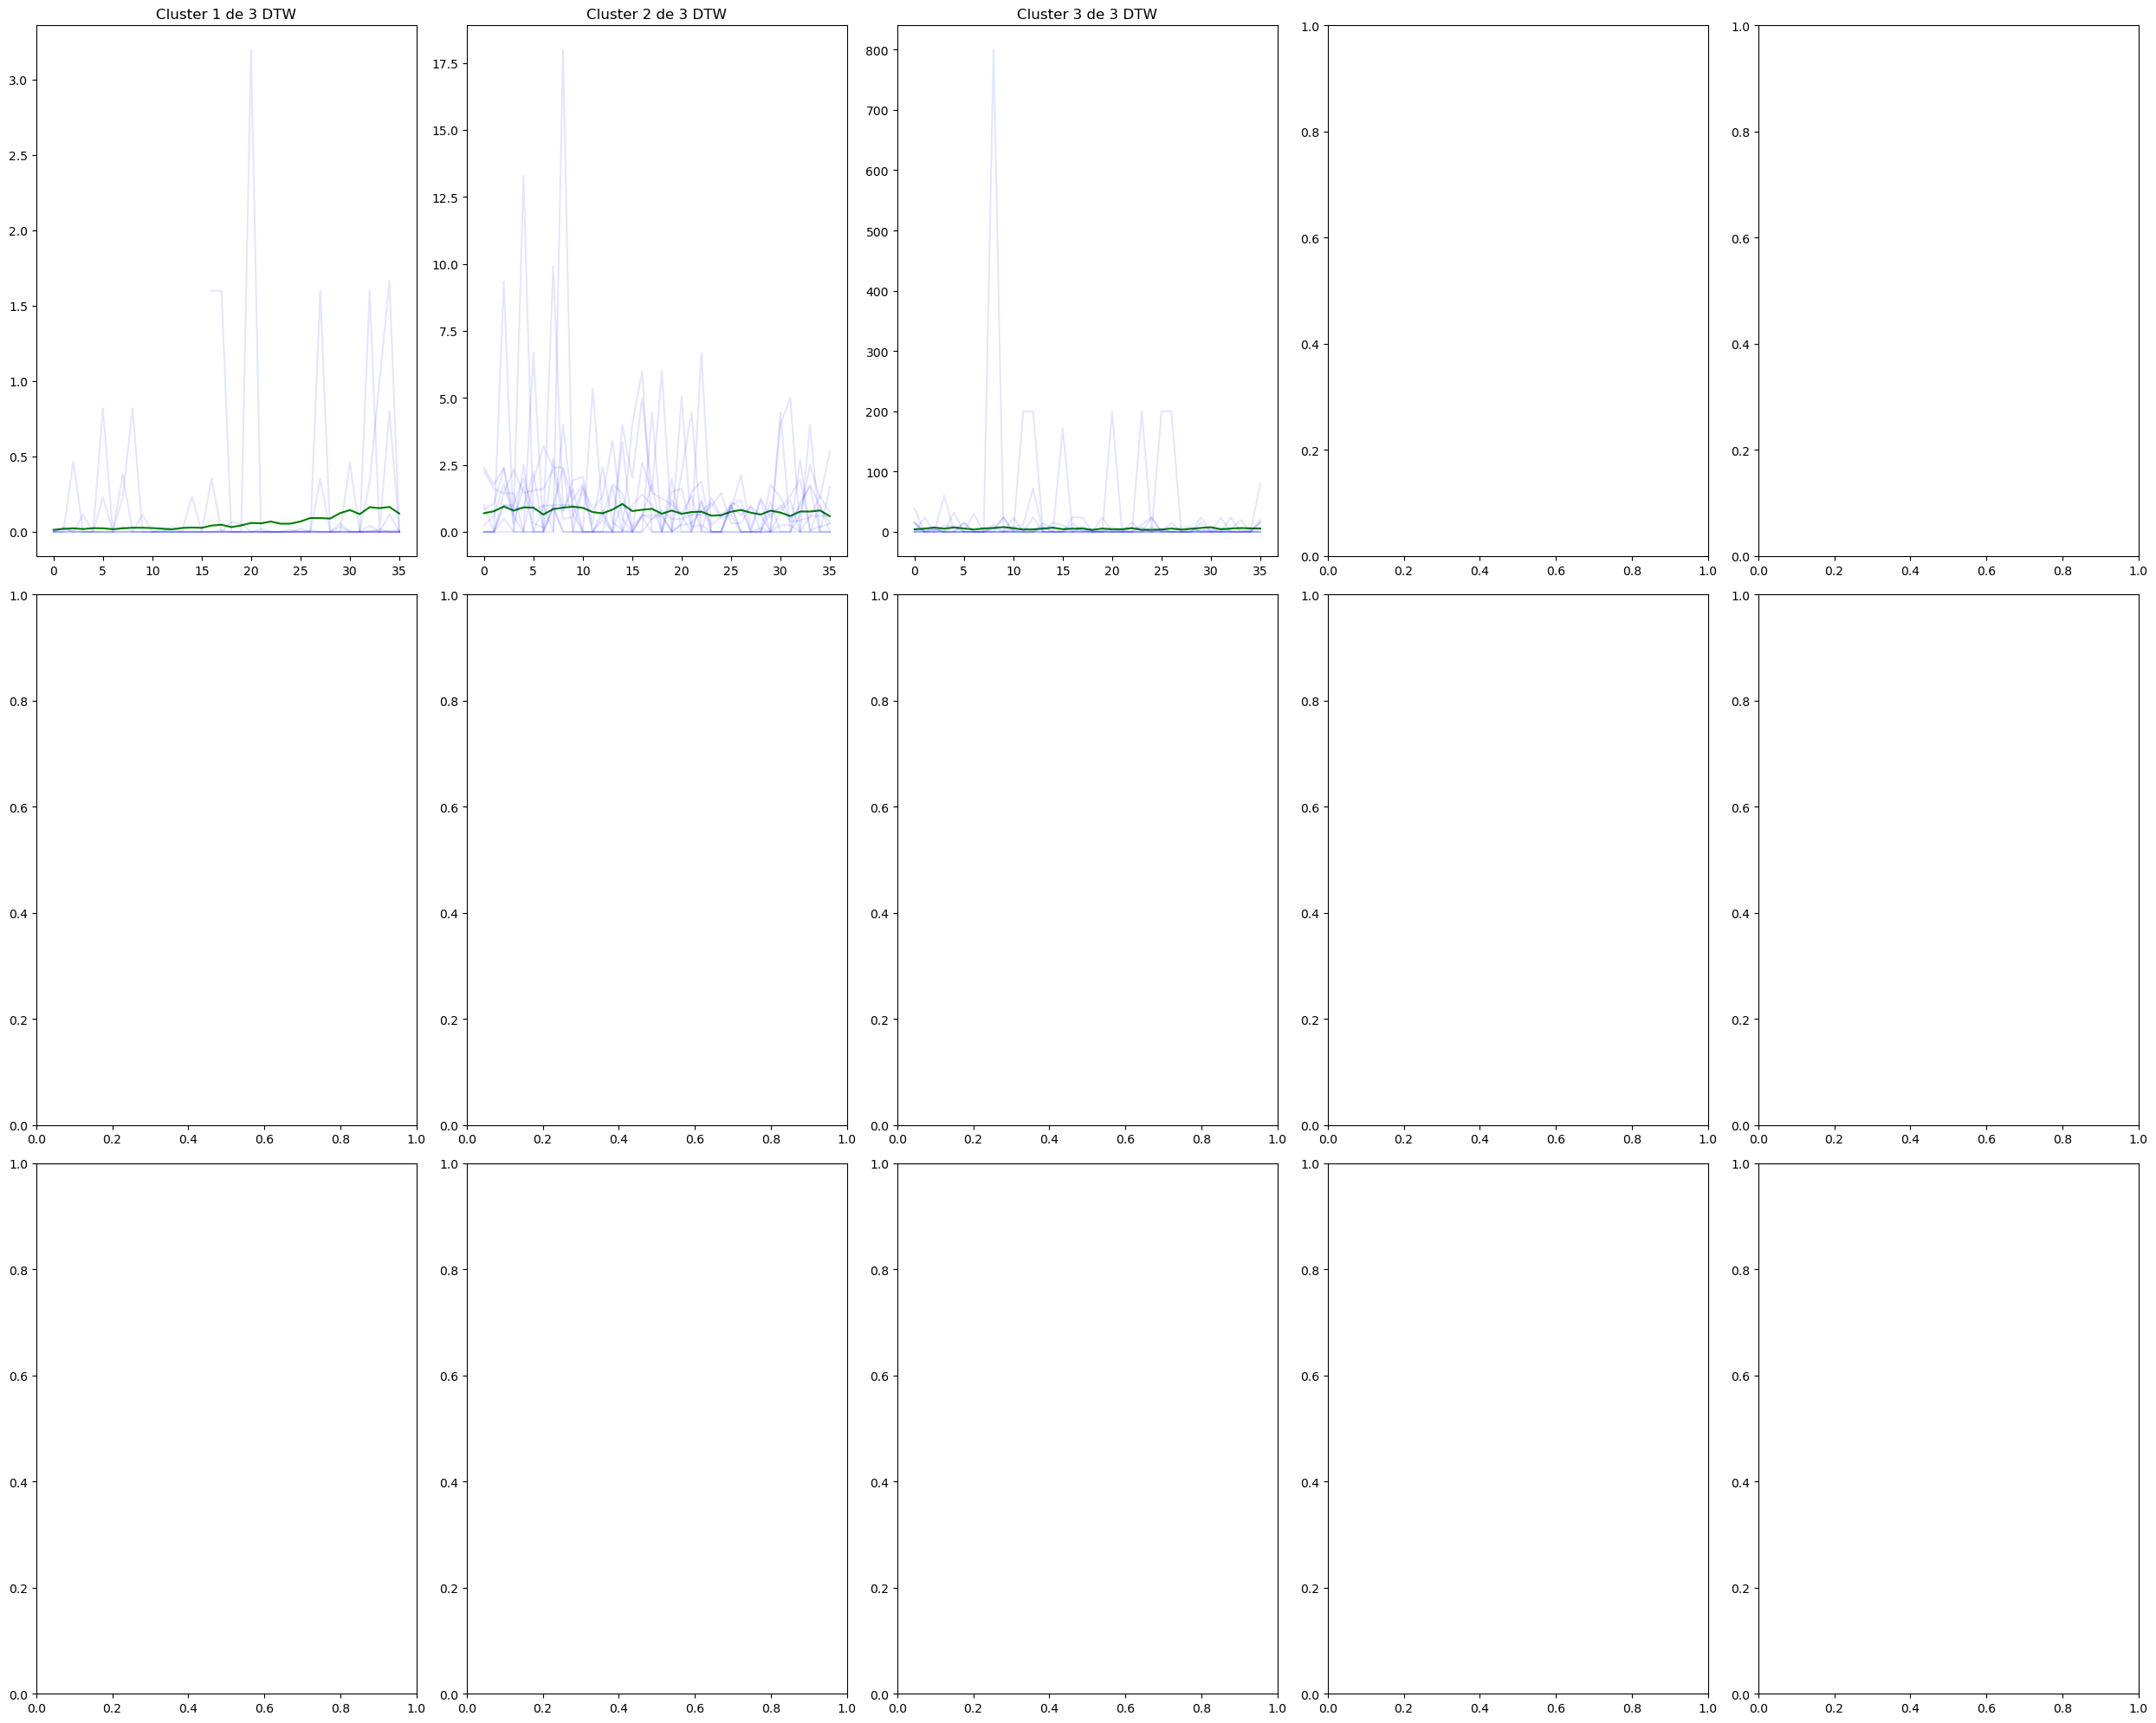

----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



a las 23:26:42
----------------------------------------------COMIENZA----------------------------------------------
--------------------------------------------03_features---------------------------------------------
Lags creados en: 7.67 a las 23:26:52
Diff creados en: 10.22 a las 23:27:02
Diff2 creados en: 2.56 a las 23:27:05
Ratios creados en: 0.82 a las 23:27:06
Promedios creados en: 6.95 a las 23:27:13
Maximos creados en: 7.26 a las 23:27:20
Minimos creados en: 7.14 a las 23:27:27
Monotonia_creciente creados en: 0.40 a las 23:27:27
Monotonia_decreciente creados en: 0.39 a las 23:27:28

Fin de creacion de metricas 43.41 a las 23:27:28
Columnas cambiadas a categorical: ['yearquarter', 'cat1', 'cat2', 'cat3', 'brand', 'descripcion']
--------------------------------------------03_fea

KeyError: "['cluster_dtw_3'] not in index"

KeyError: "['cluster_dtw_3'] not in index"

In [28]:
original_stdout = sys.stdout 

with open(f'{FOLDER}\exp_config_out.txt', 'w') as file:
    sys.stdout = file

    print(f"{'Experimento':.^120}\n{gen_config['nombre_exp']:-^120}")
    print(f"{'CARPETA':.<25}: {gen_config['folder']}")
    for k, v in gen_config.items():
        if k == 'folder' or k == 'nombre_exp':
            continue
        if k.startswith('path_'):
            print(f"{k:.<25}: {v} ( {FOLDER}{v} )")
        if k.startswith('var_'):
            print(f"{k:.<25}: {v}")

sys.stdout = original_stdout

with open(f'{FOLDER}\exp_config_out.txt', 'r') as file:
    print(file.read())

if ejecutar_scripts['01_LecturaDatos']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 01_LecturaDatos.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'01_LecturaDatos':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['02_normaliza']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 02_normaliza.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'02_normaliza':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['02b_DTW']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 02b_DTW.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'02b_DTW':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['03_features']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 03_features.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'03_features':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['04_crear_train_set']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 04_crear_train_set.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'04_crear_train_set':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['05_lightgbm']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 05_lightgbm.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'05_lightgbm':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['06_evaluar_prediccion']:
    print(f"a las {datetime.now().strftime('%H:%M:%S')}")
    %run 06_evaluar_prediccion.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'06_evaluar_prediccion':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")
